In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import platform
if platform.system() == 'Darwin': # Mac
    plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': # Windows
    plt.rc('font', family='Malgun Gothic')

plt.rcParams['axes.unicode_minus'] = False # 마이너스 기호 깨짐 방지
# --- 1. 데이터 불러오기 및 특정 특성 선택 ---
df = pd.read_csv('Location1.csv')

# 사용할 특성과 타겟 변수 리스트
selected_features = [
    'Time',
    'windspeed_100m',
    'windspeed_10m',
    'windgusts_10m',
    'dewpoint_2m'
]
target_variable = 'Power'

# 리스트에 타겟 변수 추가
all_needed_columns = selected_features + [target_variable]

# 필요한 컬럼만 선택하여 새 데이터프레임 생성
df_selected = df[all_needed_columns].copy()

# 'Time' 컬럼을 datetime 형식으로 변환하고 인덱스로 설정
df_selected['Time'] = pd.to_datetime(df_selected['Time'])
df_selected.set_index('Time', inplace=True)

# 'Power' 컬럼 이름을 'target'으로 변경
df_selected.rename(columns={'Power': 'target'}, inplace=True)


# --- 2. 결과 확인 ---
print("--- 선택된 특성으로 구성된 데이터 ---")
print("데이터 정보:")
print(df_selected.info())
print("\n데이터 샘플:")
print(df_selected.head())

--- 선택된 특성으로 구성된 데이터 ---
데이터 정보:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2017-01-02 00:00:00 to 2021-12-31 23:00:00
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   windspeed_100m  43800 non-null  float64
 1   windspeed_10m   43800 non-null  float64
 2   windgusts_10m   43800 non-null  float64
 3   dewpoint_2m     43800 non-null  float64
 4   target          43800 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB
None

데이터 샘플:
                     windspeed_100m  windspeed_10m  windgusts_10m  \
Time                                                                
2017-01-02 00:00:00            1.26           1.44            1.4   
2017-01-02 01:00:00            3.99           2.06            4.4   
2017-01-02 02:00:00            2.78           1.30            3.2   
2017-01-02 03:00:00            2.69           1.30            1.6   
2017-01-02 04:00:00            4.43      

In [2]:
from sklearn.preprocessing import StandardScaler

# --- 3. 데이터 분할 ---
n = len(df_selected)
train_end = int(n * 0.7)
val_end = int(n * (0.7 + 0.15))

# .copy()를 사용하여 SettingWithCopyWarning 방지
train_df = df_selected.iloc[:train_end].copy()
val_df = df_selected.iloc[train_end:val_end].copy()
test_df = df_selected.iloc[val_end:].copy()

print("--- 데이터 분할 결과 ---")
print(f"Train Set: {train_df.shape}")
print(f"Validation Set: {val_df.shape}")
print(f"Test Set: {test_df.shape}")


# --- 4. 데이터 스케일링 ---
# 'target'을 제외한 모든 컬럼을 feature로 선택
features = [col for col in train_df.columns if col != 'target']
scaler = StandardScaler()

print(f"\n--- {len(features)}개 Feature 스케일링 ---")

# Train 데이터에 fit 및 transform 수행
train_df[features] = scaler.fit_transform(train_df[features])

# Val, Test 데이터에는 transform만 수행
val_df[features] = scaler.transform(val_df[features])
test_df[features] = scaler.transform(test_df[features])

print("\n--- 데이터 스케일링 완료 ---")
print("스케일링 후 Train 데이터 샘플:")
train_df.head()

--- 데이터 분할 결과 ---
Train Set: (30659, 5)
Validation Set: (6571, 5)
Test Set: (6570, 5)

--- 4개 Feature 스케일링 ---

--- 데이터 스케일링 완료 ---
스케일링 후 Train 데이터 샘플:


,windspeed_100m,windspeed_10m,windgusts_10m,dewpoint_2m,target
Time,,,,,
2017-01-02 00:00:00,-1.880974,-1.311702,-1.788871,-0.667715,0.1635
2017-01-02 01:00:00,-0.869135,-0.939601,-0.957529,-0.657193,0.1424
2017-01-02 02:00:00,-1.317606,-1.395725,-1.290066,-0.667715,0.1214
2017-01-02 03:00:00,-1.350963,-1.395725,-1.733448,-0.678237,0.1003
2017-01-02 04:00:00,-0.706055,-0.693534,-1.068375,-0.688759,0.0793


In [3]:
import numpy as np

# 시계열 데이터를 입력(X)과 출력(y) 시퀀스로 변환하는 함수
def create_sequences(input_data, sequence_length, prediction_horizon):
    X, y = [], []
    features = [col for col in input_data.columns if col != 'target']
    data_len = len(input_data)
    
    for i in range(data_len - sequence_length - prediction_horizon + 1):
        # 입력 시퀀스
        sequence = input_data.iloc[i:(i + sequence_length)]
        
        # 정답(라벨)
        label_position = i + sequence_length + prediction_horizon - 1
        label = input_data.iloc[label_position]['target']
        
        X.append(sequence[features].values)
        y.append(label)
        
    return np.array(X), np.array(y)

# 시퀀스 길이와 예측 시점 정의
SEQUENCE_LENGTH = 24 * 7 # 7일 (168시간)
PREDICTION_HORIZON = 1   # 1시간 뒤

# 각 데이터셋을 시퀀스 형태로 변환
X_train, y_train = create_sequences(train_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)
X_val, y_val = create_sequences(val_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)
X_test, y_test = create_sequences(test_df, SEQUENCE_LENGTH, PREDICTION_HORIZON)

# 변환된 데이터의 형태(shape) 확인
print("--- 시퀀스 데이터 생성 완료 ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

--- 시퀀스 데이터 생성 완료 ---
X_train shape: (30491, 168, 4)
y_train shape: (30491,)
X_val shape: (6403, 168, 4)
y_val shape: (6403,)
X_test shape: (6402, 168, 4)
y_test shape: (6402,)


In [8]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# --- 5. PyTorch 데이터로더 생성 ---
BATCH_SIZE = 64

# NumPy 배열을 PyTorch Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# TensorDataset 및 DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("--- PyTorch DataLoader 준비 완료 ---")


# --- 6. LSTM 모델 정의 및 초기화 ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 하이퍼파라미터 (INPUT_SIZE가 4로 변경됨)
INPUT_SIZE = X_train.shape[2] # 4
HIDDEN_SIZE = 256
NUM_LAYERS = 2
OUTPUT_SIZE = 1
LEARNING_RATE = 0.001

# LSTM 모델 클래스
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

# 모델, 손실 함수, 옵티마이저 초기화
model_fs = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device) # Feature Selection 모델
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_fs.parameters(), lr=LEARNING_RATE)


print(f"\n--- 특성 선택 모델 준비 완료 (Device: {device}) ---")
print("모델 구조:")
print(model_fs)

--- PyTorch DataLoader 준비 완료 ---

--- 특성 선택 모델 준비 완료 (Device: cuda) ---
모델 구조:
LSTMModel(
  (lstm): LSTM(4, 256, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


--- 특성 선택 모델(LSTM) 학습 시작 ---


Epoch 1/50 [Train]: 100%|██████████| 477/477 [00:10<00:00, 45.68it/s, loss=0.0339]


Epoch 1/50 | Train Loss: 0.030852 | Val Loss: 0.028666


Epoch 2/50 [Train]: 100%|██████████| 477/477 [00:10<00:00, 46.01it/s, loss=0.0193]


Epoch 2/50 | Train Loss: 0.026404 | Val Loss: 0.027507


Epoch 3/50 [Train]: 100%|██████████| 477/477 [00:10<00:00, 46.03it/s, loss=0.0251]


Epoch 3/50 | Train Loss: 0.025876 | Val Loss: 0.028087


Epoch 4/50 [Train]: 100%|██████████| 477/477 [00:10<00:00, 45.75it/s, loss=0.0256]


Epoch 4/50 | Train Loss: 0.025482 | Val Loss: 0.026990


Epoch 5/50 [Train]: 100%|██████████| 477/477 [00:11<00:00, 42.84it/s, loss=0.0271]


Epoch 5/50 | Train Loss: 0.025131 | Val Loss: 0.026801


Epoch 6/50 [Train]: 100%|██████████| 477/477 [00:25<00:00, 18.86it/s, loss=0.0226]


Epoch 6/50 | Train Loss: 0.024641 | Val Loss: 0.027238


Epoch 7/50 [Train]: 100%|██████████| 477/477 [00:30<00:00, 15.59it/s, loss=0.0216]


Epoch 7/50 | Train Loss: 0.024469 | Val Loss: 0.027130


Epoch 8/50 [Train]: 100%|██████████| 477/477 [00:31<00:00, 14.94it/s, loss=0.032] 


Epoch 8/50 | Train Loss: 0.024021 | Val Loss: 0.027939


Epoch 9/50 [Train]: 100%|██████████| 477/477 [00:33<00:00, 14.45it/s, loss=0.0235] 


Epoch 9/50 | Train Loss: 0.023347 | Val Loss: 0.026814


Epoch 10/50 [Train]: 100%|██████████| 477/477 [00:37<00:00, 12.80it/s, loss=0.0171] 


Epoch 10/50 | Train Loss: 0.022819 | Val Loss: 0.027530
Early stopping triggered.

--- 학습 종료 (총 학습 시간: 226.00초) ---
최적 모델 'best_model_fs.pth' 로드 완료.


[Final Test]: 100%|██████████| 101/101 [00:02<00:00, 35.89it/s]



--- 특성 선택 모델 최종 성능 평가 결과 ---
MAE: 0.1203
RMSE: 0.1535
R-squared (결정 계수): 0.7150


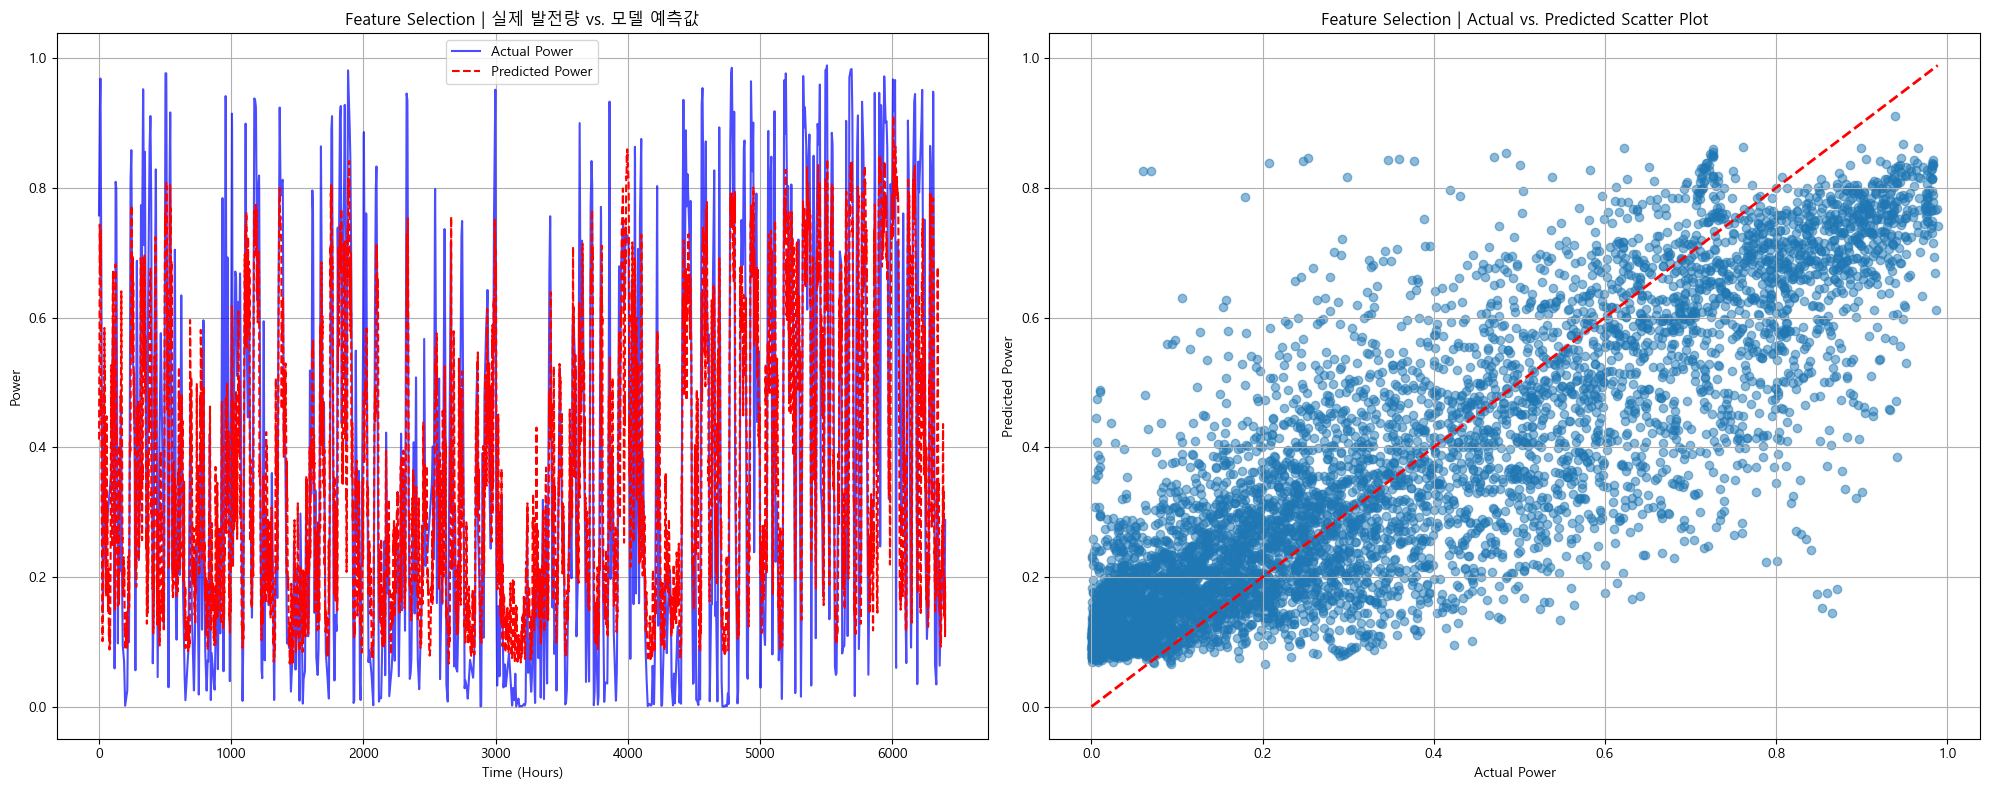

In [9]:
import time
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- 7. 특성 선택 모델 학습 및 평가 ---

NUM_EPOCHS = 50
PATIENCE = 5
best_val_loss = float('inf')
early_stopping_counter = 0
best_model_path_fs = 'best_model_fs.pth' # Feature Selection 모델 파일 이름

print("--- 특성 선택 모델(LSTM) 학습 시작 ---")
start_time = time.time()

for epoch in range(NUM_EPOCHS):
    model_fs.train()
    train_loss = 0.0
    train_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS} [Train]")

    for inputs, labels in train_iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_fs(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_iterator.set_postfix({'loss': loss.item()})
    
    avg_train_loss = train_loss / len(train_loader)

    model_fs.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_fs(inputs)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()
            
    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_fs.state_dict(), best_model_path_fs)
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
    
    if early_stopping_counter >= PATIENCE:
        print("Early stopping triggered.")
        break

end_time = time.time()
print(f"\n--- 학습 종료 (총 학습 시간: {end_time - start_time:.2f}초) ---")

# --- 최종 평가 ---
model_fs.load_state_dict(torch.load(best_model_path_fs))
print(f"최적 모델 '{best_model_path_fs}' 로드 완료.")

model_fs.eval()
all_predictions = []
all_actuals = []

with torch.no_grad():
    test_iterator = tqdm(test_loader, desc="[Final Test]")
    for inputs, labels in test_iterator:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_fs(inputs)
        all_predictions.append(outputs.squeeze().cpu().numpy())
        all_actuals.append(labels.cpu().numpy())

predictions = np.concatenate(all_predictions)
actuals = np.concatenate(all_actuals)

mae = mean_absolute_error(actuals, predictions)
rmse = np.sqrt(mean_squared_error(actuals, predictions))
r2 = r2_score(actuals, predictions)

print("\n--- 특성 선택 모델 최종 성능 평가 결과 ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R-squared (결정 계수): {r2:.4f}")

# --- 결과 시각화 ---
plt.figure(figsize=(20, 8))

plt.subplot(1, 2, 1)
plt.plot(actuals, label='Actual Power', color='blue', alpha=0.7)
plt.plot(predictions, label='Predicted Power', color='red', linestyle='--')
plt.title('Feature Selection | 실제 발전량 vs. 모델 예측값')
plt.xlabel('Time (Hours)')
plt.ylabel('Power')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], color='red', linestyle='--', lw=2)
plt.title('Feature Selection | Actual vs. Predicted Scatter Plot')
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.grid(True)

plt.tight_layout()
plt.show()